In [1]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy

In [2]:
def BoseHubbard_ham(t, U, ttn):
    # Generate bosonic operators
    creation_op, annihilation_op, number_op = ptn.bosonic_operators()
    
    # Define conversion dictionary
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        "I2": np.eye(2),
        "I4": np.eye(4)
    }
    
    # Add scaled operators to the dictionary
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(2))
    })
    
    # Define terms in the Hamiltonian
    terms = []
    
    # Hopping terms
    for identifier, node in ttn.nodes.items():
        for child in node.children:
            terms.append(ptn.TensorProduct({identifier: "-t * b^dagger", child: "b"}))
            terms.append(ptn.TensorProduct({identifier: "-t * b", child: "b^dagger"}))
    
    # On-site interaction terms
    for identifier, node in ttn.nodes.items():
        terms.append(ptn.TensorProduct({identifier: "U * n * (n - 1)"}))
    
    # Construct and return the Hamiltonian
    return ptn.Hamiltonian(terms, conversion_dict)

def pad_ttn_with_zeros(ttn, bond_dim):
    padded_ttn = deepcopy(ttn)
    for node_id in padded_ttn.nodes.keys():
        n = padded_ttn.tensors[node_id].ndim - 1
        tensor = padded_ttn.tensors[node_id]
        T = np.pad(tensor, n*((0, bond_dim-2),) + ((0, 0),))
        padded_ttn.tensors[node_id] = T
        padded_ttn.nodes[node_id].link_tensor(T)
    return padded_ttn

In [10]:
ttn1 = ptn.random_big_ttns_two_root_children()

In [7]:
shapes = [(2,2,2),(2,2,2,2),(2,2),(2,2,2,2),
        (2,2),(2,2,2),(2,2,2,2),(2,2,2,2),(2,2,2),(2,2),(2,2),(2,2),(2,2)]

nodes = [ptn.random_tensor_node(shape, identifier="site"+str(i))
        for i, shape in enumerate(shapes)]
ttn1 = ptn.TreeTensorNetworkState()
ttn1.add_root(nodes[0][0], nodes[0][1])
ttn1.add_child_to_parent(nodes[1][0],nodes[1][1],0,"site0",0)
ttn1.add_child_to_parent(nodes[2][0],nodes[2][1],0,"site1",1)
ttn1.add_child_to_parent(nodes[3][0],nodes[3][1],0,"site1",2)
ttn1.add_child_to_parent(nodes[4][0],nodes[4][1],0,"site3",1)
ttn1.add_child_to_parent(nodes[5][0],nodes[5][1],0,"site3",2)
ttn1.add_child_to_parent(nodes[6][0],nodes[6][1],0,"site0",1)
ttn1.add_child_to_parent(nodes[7][0],nodes[7][1],0,"site6",1)
ttn1.add_child_to_parent(nodes[8][0],nodes[8][1],0,"site7",1)
ttn1.add_child_to_parent(nodes[9][0],nodes[9][1],0,"site8",1)
ttn1.add_child_to_parent(nodes[10][0],nodes[10][1],0,"site5",1)
ttn1.add_child_to_parent(nodes[11][0],nodes[11][1],0,"site7",2)
ttn1.add_child_to_parent(nodes[12][0],nodes[12][1],0,"site6",2)

ttn1.normalize_ttn()

H1 = BoseHubbard_ham(4, 5, ttn1)
# H1 = H1.pad_with_identities(ttn1 , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn1)

possible_operators = [ptn.random_hermitian_matrix(2) for _ in range(6)] 
tp = ptn.random_tensor_product(ref_tree= ttn1,
                                num_operators= 8,
                                possible_operators= possible_operators,
                                factor= 40)

In [4]:
initial_state , state_order = ttn1.completely_contract_tree(tp)
initial_state_vector = initial_state.reshape(-1)

hamiltonian , ham_order = ttno.completely_contract_tree(tp)
print(ham_order)

hamiltonian = np.transpose(hamiltonian,(0,2,4,6,8,10,14,16,18,20,12,22,24,1,3,5,7,9,11,15,17,19,21,13,23,25))
hamiltonian_matrix = np.reshape(hamiltonian,(2**13,2**13))

tp = tp.pad_with_identities(ttn1, symbolic= False)
operators = tp.into_operator( order = ham_order) 
operators = operators.operator

['site0', 'site1', 'site2', 'site3', 'site4', 'site5', 'site10', 'site6', 'site7', 'site8', 'site9', 'site11', 'site12']


In [ ]:
exact = ptn.ExactTimeEvolution(initial_state = initial_state_vector, 
                               hamiltonian = hamiltonian_matrix, 
                               time_step_size = 0.001,
                               final_time= 0.1,
                               operators= operators)

exact.run(evaluation_time=2)

times = exact.times()
exact_results = exact.operator_results(realise=True)[0]

In [ ]:
tdvp = ptn.SecondOrderTwoSiteTDVP(initial_state = ttn1,
                                  hamiltonian = ttno,
                                  time_step_size = 0.001,
                                  final_time = 0.1,
                                  operators = tp,
                                  truncation_parameters= ptn.SVDParameters(max_bond_dim= np.inf, rel_tol= 0.0001, total_tol= -np.inf),
                                  config = None)

In [ ]:
tdvp.run(evaluation_time=2)

times = tdvp.times()
tdvp_results = tdvp.operator_results(realise=True)[0]

100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


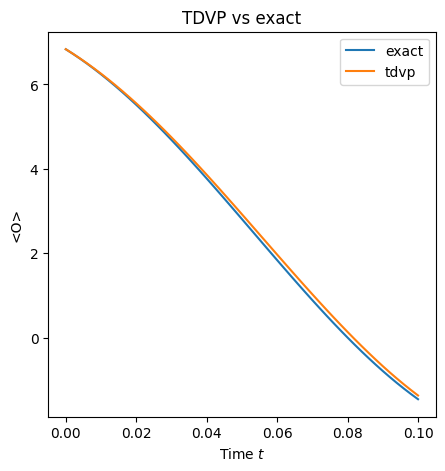

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

# First plot
axs1.plot(times, exact_results, label='exact')
axs1.plot(times, tdvp_results, label='tdvp')

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("<O>")
axs1.set_title("TDVP vs exact")

# Add a legend to distinguish between the two plots
axs1.legend()

plt.show()